# Clasificación usando Árbol de decisión

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Abril de 2024  
**Versión:** 1.0  

**Fecha de actualización:** Enero de 2025  
**Versión:** 1.1  


**Fecha de actualización:** Octubre de 2025  
**Versión:** 1.2  

---

## Descripción

Este notebook contiene la explicación de la creación de un modelo de clasificación usando `DecisionTreeClassifier`.

Utiliza un conjunto de datos de predicción de diabetes. Este conjunto de datos contiene una serie de parámetros fisiológicos de un paciente.

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.12. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)
- matplotlib (3.7.1)
- seaborn (0.13.1)

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```python
import pandas as pd
print(pd.__version__)
````

# Árboles de decisión



---


Los árboles de decisión son métodos de machine learning (aprendizaje de máquinas) muy utilizados debido a su buen rendimiento y su explicabilidad.

Un árbol de decisión no siempre tiene buen rendimiento, por lo que se proponen técnicas de ensamble de árboles de decisión aislados (`RandomForest`) para generar un estimador más robusto que el estimador único por el que está conformado el ensamble.



---



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score,  classification_report

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

En todas las variables, exceptuando las variables binarias, se controla los efectos de los valores outliers (`winsorized`) en los percentiles 5 y 95.

---

**NOTA**. Revisar un notebook general donde se explica esta técnica de tratamiento de atípicos.

In [ ]:
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=(0.05, 0.05)):
        self.limits = limits

    def fit(self, X, y=None):
        # Guardar nombres si es DataFrame, si no generar nombres genéricos
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
        else:
            self.columns_ = np.arange(X.shape[1])
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns_)
        for col in self.columns_:
            lower = X[col].quantile(self.limits[0])
            upper = X[col].quantile(1 - self.limits[1])
            X[col] = np.clip(X[col], lower, upper)
        return X.values

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(self.columns_)
        else:
            return np.array(input_features)

In [ ]:
!wget https://www.dropbox.com/s/lus9jhalh6j65qt/diabetes.csv

--2025-11-11 11:59:17--  https://www.dropbox.com/s/lus9jhalh6j65qt/diabetes.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/6ngpmrhofnz5fqf86efv5/diabetes.csv?rlkey=qndgwm5jvy70qf02wzlcbac11 [following]
--2025-11-11 11:59:18--  https://www.dropbox.com/scl/fi/6ngpmrhofnz5fqf86efv5/diabetes.csv?rlkey=qndgwm5jvy70qf02wzlcbac11
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc36fe409197c44057b0a5fe5168.dl.dropboxusercontent.com/cd/0/inline/C0-5VZqPcLRuC8_Fuj5V9VCNiIC4AXVZqUdmChqkMu7FjgZbHA86vxXOWzfa2oApAso9R9c7ofrblpZCSQFe2LyOvNF0Cp5ifevVcPbp8USMXBGIoSrj0gXq1bfIrJHOLbbRCUgtMm7azz1p5kg-Jaoc/file# [following]
--2025-11-11 11:59:18--  https://uc36fe409197c44057b0a5fe5168.dl.dropboxusercontent.com/cd/0/inline/C

In [ ]:
diabetes = pd.read_csv("diabetes.csv")

In [ ]:
diabetes.shape

(768, 9)

In [ ]:
diabetes.sample(4)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
233,4,122,68,0,0,35.0,0.394,29,0
477,7,114,76,17,110,23.8,0.466,31,0
585,1,93,56,11,0,22.5,0.417,22,0
428,0,135,94,46,145,40.6,0.284,26,0


Para ilustrar la construcción de un árbol de decisión utilizaremos sólo un par de variables del conjunto de datos.

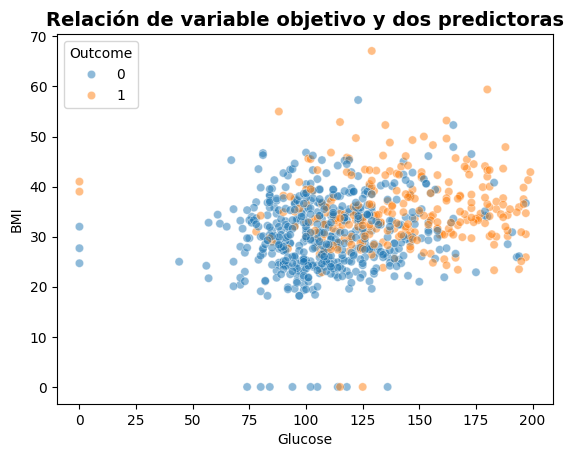

In [ ]:
sns.scatterplot(
    data = diabetes,
    x = "Glucose",
    y = "BMI",
    hue = "Outcome",
    alpha = 0.5
)
plt.title("Relación de variable objetivo y dos predictoras", fontsize=14, fontweight="bold")
plt.show()

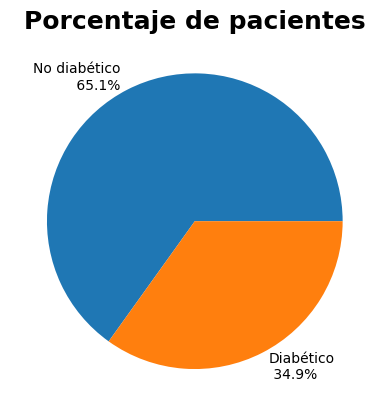

In [ ]:
# Gráfico de torta del porcentaje de pacientes
clases = np.array([diabetes[diabetes.Outcome == 0.0].shape[0],
                   diabetes[diabetes.Outcome == 1.0].shape[0]])

# Leyendas del gráfico.
labels = [ str(round(x * 1.0 / clases.sum() * 100.0, 2)) + '%'  for x in clases ]
labels[0] = 'No diabético\n ' + labels[0]
labels[1] = 'Diabético\n ' + labels[1]

plt.pie(clases, labels=labels)
plt.title('Porcentaje de pacientes', fontsize=18, fontweight="bold")
plt.show()

---
**Hallazgos**

---

+ Se aprecia un desbalance de clases siendo mayoritaria la clase `negativa`que en este caso corresponde a `Paciente no diabético`.

+ Lo anterior, debe ser considerado al momento de interpretar las métricas del modelo de clasificación porque una de ellas es sensible al desbalance de clases.

# Árbol de decisión

Para la construcción de un árbol de decisión, primero se debe definir una métrica a optimizar. En el caso de los árboles de decisión, una métrica que se puede
optimizar es la *entropía*. En donde a medida que se van tomando decisiones se busca `ganar información` o `disminuir la entropía`.

La definición de entropía a utilizar es la siguiente:

$$
H(X)=- \sum_{i}p(x_i) \log_2 p(x_i)
$$

Donde $X$ es el conjunto de etiquetas.

In [ ]:
def entropy(data : np.array) -> float:
  """
  Calcula la entropía de un conjunto de datos.

  Parámetros
  ----------
  data : np.array
    Conjunto de datos.

  Retorna
  -------
  float
    Entropía del conjunto de datos.
  """
  classes = np.unique(data)
  entropies = []
  for c in classes:
    p = sum(data == c) / len(data)
    current_entropy = p * np.log2(p)
    entropies.append(current_entropy)
  return -1 * sum(entropies)

Para comenzar, se puede estimar la entropía total del conjunto de datos

In [ ]:
entropy(diabetes.Outcome)

np.float64(0.9331343166407831)

Ahora, se debe tomar una decisión, con la cual se busca `disminuir la entropía` de cada uno de los subconjuntos obtenidos posterior a la decisión.

In [ ]:
entropy(diabetes.Outcome[diabetes.Glucose >= 175])

np.float64(0.6699960320994333)

In [ ]:
entropy(diabetes.Outcome[diabetes.Glucose < 175])

np.float64(0.8941290186253704)

Para estimar la entropía general de la decisión que se ha tomado se debe calcular un promedio ponderado de cada una de las entropías de cada subconjunto de datos.

In [ ]:
def weighted_entropy(data : pd.DataFrame, feature : str, label : str, threshold : int):
  """
  Calcula la entropía ponderada de un conjunto de datos.

  Parámetros
  ----------
  data : pd.DataFrame
    Conjunto de datos.
  feature : str
    Variable de decisión.
  label : str
    Variable objetivo.
  threshold : int
    Umbral de decisión.

  Retorna
  -------
  float
    Entropía ponderada del conjunto de datos.
  """
  indices = data[feature] >= threshold
  entropy_0 = entropy(data[label][indices])
  entropy_1 = entropy(data[label][~indices])
  return entropy_0 * (sum(indices) / len(indices)) + entropy_1 * (sum(~indices) / len(indices))


In [ ]:
weighted_entropy(diabetes, "Glucose", "Outcome", 175)

np.float64(0.8774941485316485)

Para determinar la mejor variable y el mejor umbral para la decisión del nodo del árbol se debe **optimizar** la ganancia de información de la decisión con la siguiente definición:

$$
IG(Y,X) = E(Y) - E(Y|X)
$$

Donde a la entropía total del conjunto de datos $E(Y)$ se le resta la entropía promedio $E(Y|X)$ de la decisión $Y$.

In [ ]:
entropy(diabetes.Outcome) - weighted_entropy(diabetes, "Glucose", "Outcome", 175)

np.float64(0.055640168109134525)

Se calculan las entropías asociadas a un barrido de umbrales en un par de variables.

In [ ]:
glucose_information_gain_sweep = []
glucose_thresholds = np.linspace(diabetes.Glucose.min(), diabetes.Glucose.max(), 100)
for threshold in glucose_thresholds:
  glucose_information_gain_sweep.append(entropy(diabetes.Outcome) - weighted_entropy(diabetes, "Glucose", "Outcome", threshold))

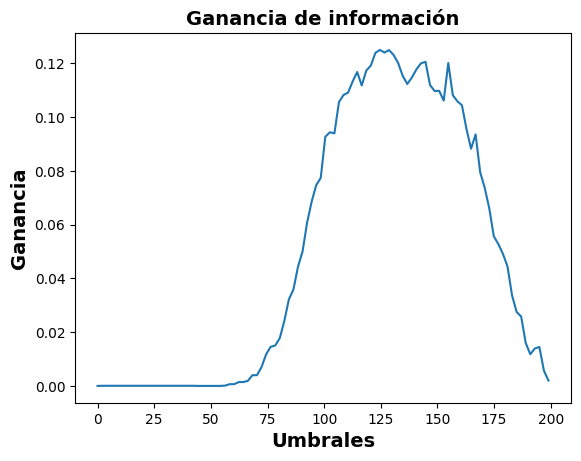

In [ ]:
# Gráfica de los resultados anteriores
sns.lineplot(
    x = glucose_thresholds,
    y = glucose_information_gain_sweep
)
plt.title("Ganancia de información", fontsize=14, fontweight="bold")
plt.xlabel("Umbrales", fontsize=14, fontweight="bold")
plt.ylabel("Ganancia", fontsize=14, fontweight="bold");

In [ ]:
bmi_information_gain_sweep = []
bmi_thresholds = np.linspace(diabetes.BMI.min(), diabetes.BMI.max(), 100)
for threshold in bmi_thresholds:
  bmi_information_gain_sweep.append(entropy(diabetes.Outcome) - weighted_entropy(diabetes, "BMI", "Outcome", threshold))

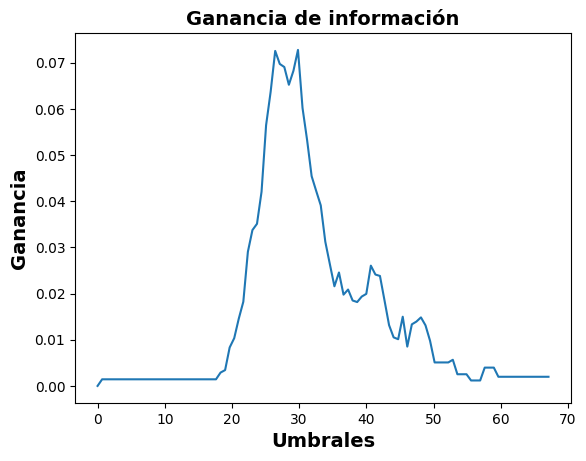

In [ ]:
sns.lineplot(
    x = bmi_thresholds,
    y = bmi_information_gain_sweep
)
plt.title("Ganancia de información", fontsize=14, fontweight="bold")
plt.xlabel("Umbrales", fontsize=14, fontweight="bold")
plt.ylabel("Ganancia", fontsize=14, fontweight="bold");

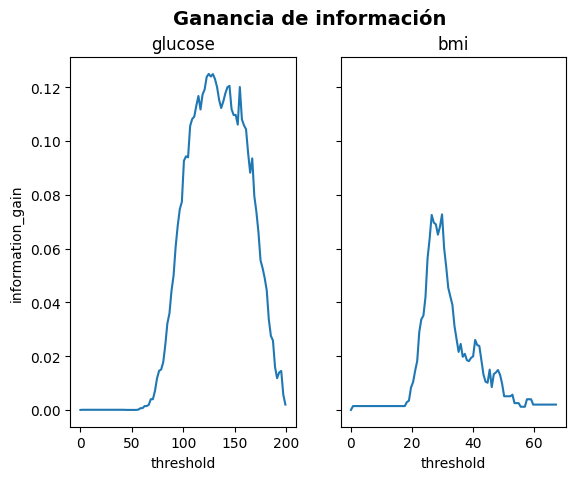

In [ ]:
fig, axs = plt.subplots(nrows=1,ncols=2, sharey=True)
sns.lineplot(
    x = glucose_thresholds,
    y = glucose_information_gain_sweep,
    ax = axs[0]
)
sns.lineplot(
    x = bmi_thresholds,
    y = bmi_information_gain_sweep,
    ax = axs[1]
)
axs[0].set_title("glucose")
axs[1].set_title("bmi")
axs[0].set_ylabel("information_gain")
axs[0].set_xlabel("threshold")
axs[1].set_xlabel("threshold")
plt.suptitle("Ganancia de información",fontsize=14, fontweight="bold");

Selecciona el umbral que aporta la mayor ganancia de información.

In [ ]:
optimal_glucose_threshold = glucose_thresholds[np.argmax(glucose_information_gain_sweep)]
optimal_glucose_threshold

np.float64(124.62626262626262)

In [ ]:
entropy(diabetes.Outcome[diabetes.Glucose >= optimal_glucose_threshold])

np.float64(0.9773203829731114)

In [ ]:
entropy(diabetes.Outcome[diabetes.Glucose < optimal_glucose_threshold])

np.float64(0.6930190480473644)

Se utiliza la implementación del árbol de decisión de `sklearn` para calcular la misma decisión.

In [ ]:
single_decision = DecisionTreeClassifier(max_depth=1, criterion = "entropy")
single_decision = single_decision.fit(diabetes[["Glucose", "BMI"]], diabetes.Outcome)

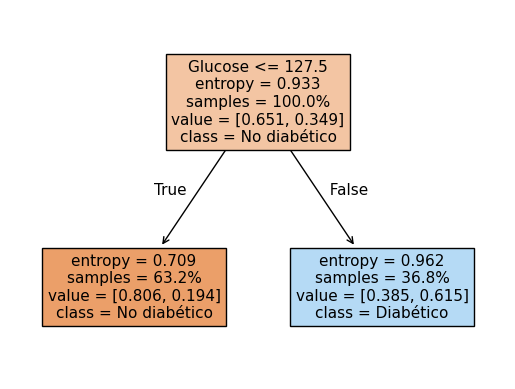

In [ ]:
plot_tree( # Función que permite visualizar el árbol de decisión ajustado.
    single_decision, # Objeto de nuestro árbol de decisión entrenado.
    feature_names = ["Glucose", "BMI"], # Nombres de las variables utilizadas para entrenar.
    class_names = ["No diabético","Diabético"], # Nombre de las clases que estamos prediciendo.
    label = "all", # Etiqueta todas características de cada nodo.
    proportion = True, # Visualizamos las proporciones de datos en cada nodo de decisión,
    filled=True, # Colorea los nodos
    fontsize=11, # Establece el tamaño de la letra del texto dentro de cada nodo.
)
plt.show()

Se prepara el conjunto de datos para poder ajustar un árbol de decisión de mayor profundidad.

In [ ]:
diabetes.dtypes

,0
Pregnancies,int64
Glucose,int64
BloodPressure,int64
SkinThickness,int64
Insulin,int64
BMI,float64
DiabetesPedigreeFunction,float64
Age,int64
Outcome,int64


In [ ]:
features_num = np.array(diabetes.iloc[:,:-1].columns)
features_num

array(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype=object)

In [ ]:
features_num = np.array(diabetes.iloc[:,:-1].columns)
features_cat = [] # En este caso NO hay variables categóricas disponibles

# Preprocesamiento numérico: tratamiento atípicos  + imputación con media  + escalado estándar
numeric_transformer = Pipeline(steps=[
    ("winsorizer", Winsorizer()),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())])

# Preprocesamiento categórico: imputación + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))])

# Combina en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features_num),
        ("cat", categorical_transformer, features_cat)], remainder="drop")

pipeline_clasificacion = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier( # Instancia el árbol de decisión.
                  max_depth=3, # Fuerza a que el árbol sólo tenga 3 niveles de profundidad.
                  criterion = "entropy"
    ))
    ])

In [ ]:
diabetes_features = diabetes.iloc[:,:-1]
diabetes_label = diabetes.Outcome

In [ ]:
(
    X_train,
    X_test,
    y_train,
    y_test
) = train_test_split(diabetes_features, diabetes_label, test_size=0.2, random_state=29, stratify=diabetes_label)

In [ ]:
pipeline_clasificacion.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  array(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype=object)),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [ ]:
pipeline_clasificacion.score(X_test, y_test)

0.7532467532467533

In [ ]:
print(classification_report(
    y_test,
    pipeline_clasificacion.predict(X_test), target_names=["No diabético","Diabético"]
))

              precision    recall  f1-score   support

No diabético       0.75      0.94      0.83       100
   Diabético       0.79      0.41      0.54        54

    accuracy                           0.75       154
   macro avg       0.77      0.67      0.68       154
weighted avg       0.76      0.75      0.73       154



In [ ]:
modelo_arbol = pipeline_clasificacion.named_steps["classifier"]

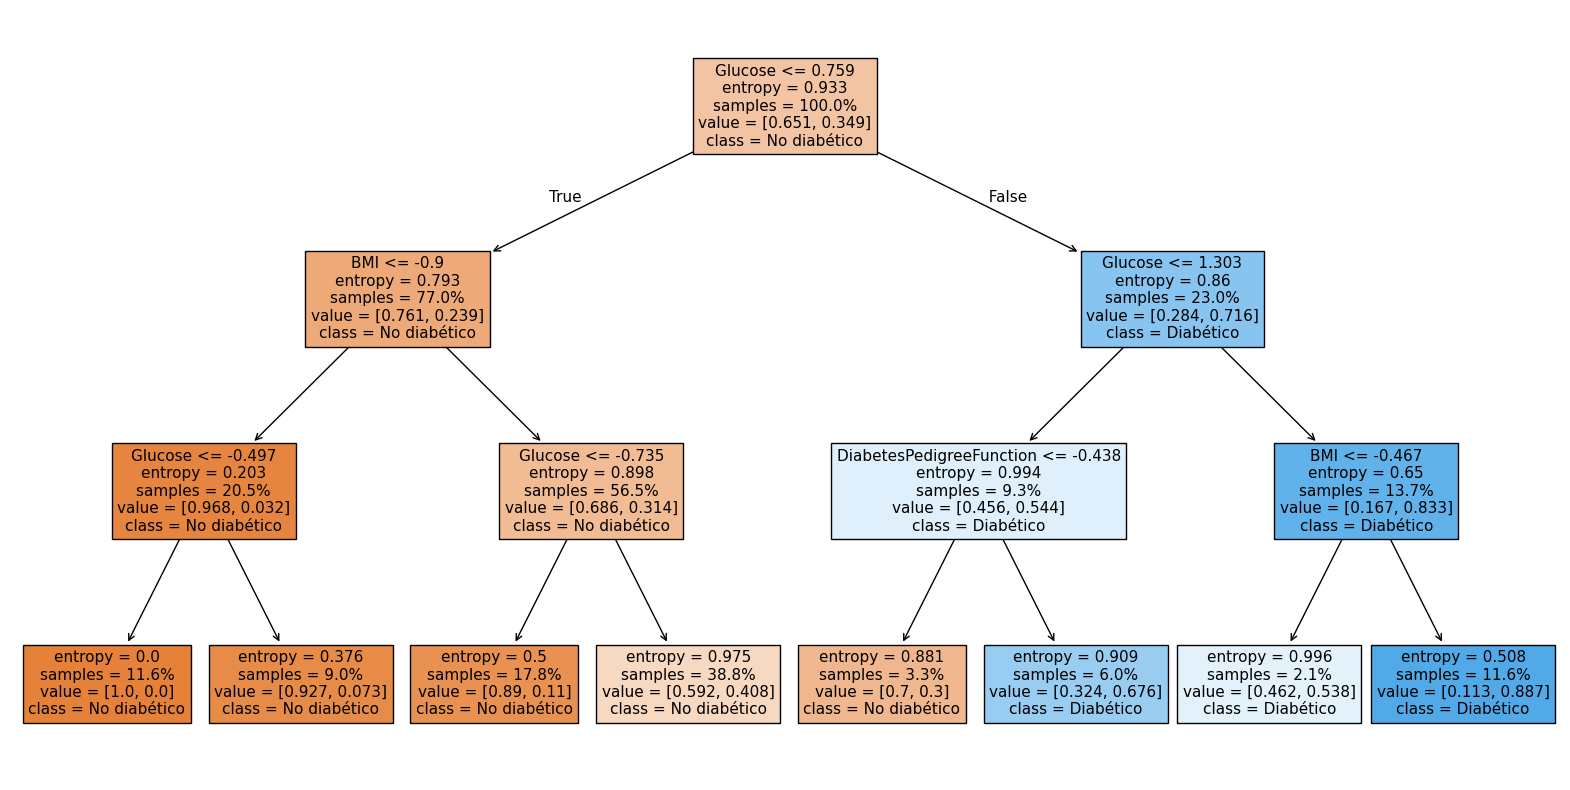

In [ ]:
plt.figure(figsize = (20,10))
plot_tree( # Función que permite visualizar el árbol de decisión ajustado.
    modelo_arbol, # Objeto que representa el árbol de decisión entrenado.
    feature_names = diabetes_features.columns, # Nombres de las variables utilizadas para entrenar.
    class_names = ["No diabético","Diabético"], # Nombre de las clases que se están prediciendo.
    label = "all", # Etiqueta todas características de cada nodo.
    proportion = True, # Visualiza las proporciones de datos en cada nodo de decisión,
    filled=True, # Colorea los nodos
    fontsize=11, # Establece el tamaño de la letra del texto dentro de cada nodo.
)
plt.show()

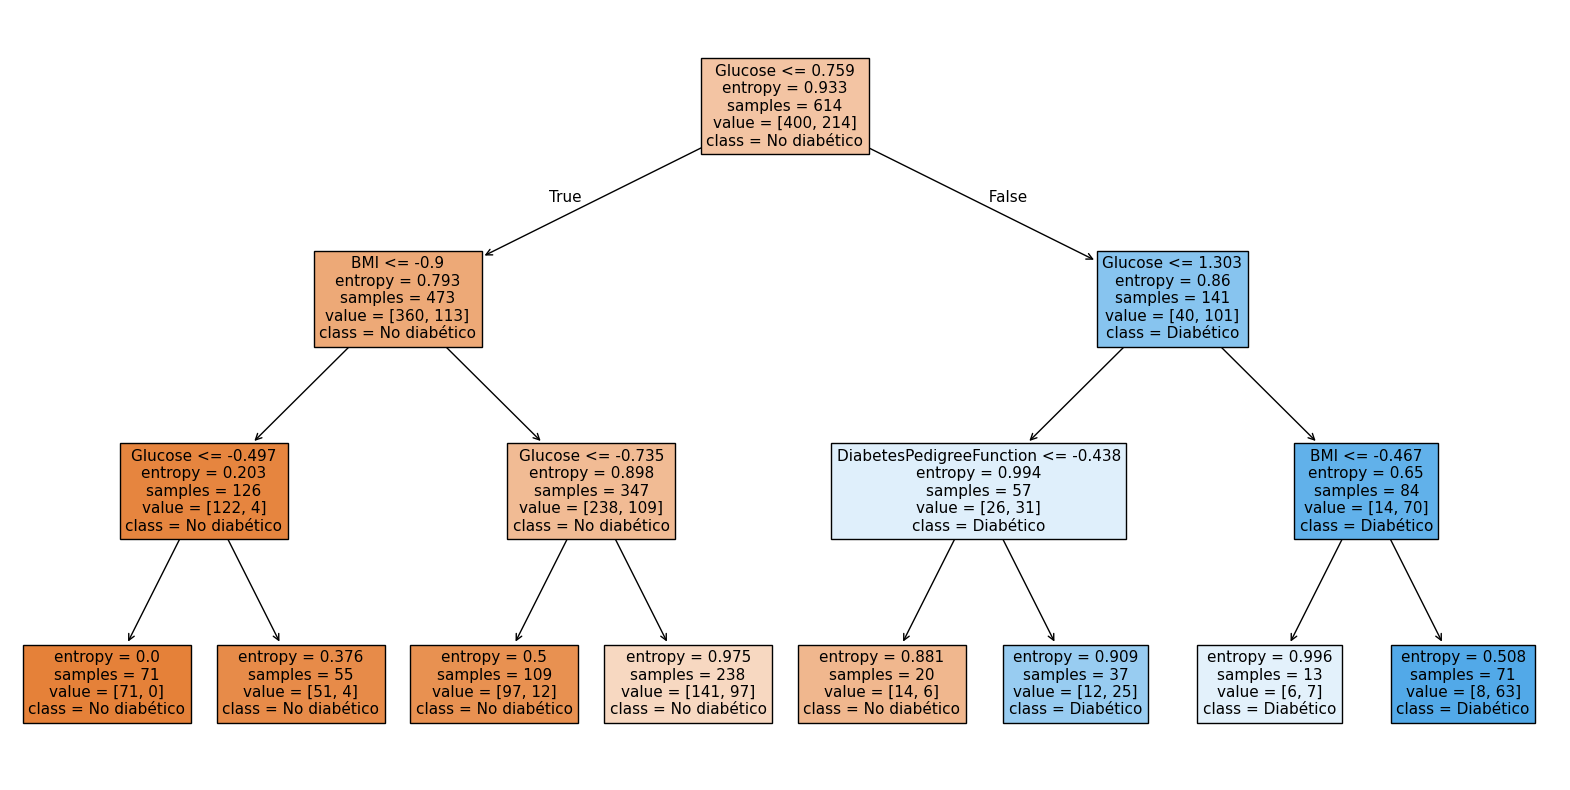

In [ ]:
plt.figure(figsize = (20,10))
plot_tree( # Función que permite visualizar el árbol de decisión ajustado.
    modelo_arbol, # Objeto que representa el árbol de decisión entrenado.
    feature_names = diabetes_features.columns, # Nombres de las variables utilizadas para entrenar.
    class_names = ["No diabético","Diabético"], # Nombre de las clases que se están prediciendo.
    label = "all", # Etiqueta todas características de cada nodo.
    proportion = False, # NO visualiza las proporciones de datos en cada nodo de decisión,
    filled=True, # Colorea los nodos
    fontsize=11, # Establece el tamaño de la letra del texto dentro de cada nodo.
)
plt.show()

En caso de que existan variables categóricas las cuales serían transformadas usando OneHotEncoder primero se debería extraer el nombre de las columnas transformadas para que aparezcan en el diagrama del árbol:

```python
# Nombres de las columnas transformadas (útil si hay variables categóricas porque se usa OneHotEncoder)
columnas_transformadas = pipeline_clasificacion.named_steps["preprocessor"].get_feature_names_out()
```

Y luego el ploteo del árbol debería quedar así:

```python
plt.figure(figsize = (20,10))
plot_tree( # Función que permite visualizar el árbol de decisión ajustado.
    modelo_arbol, # Objeto que representa el árbol de decisión entrenado.
    feature_names = columnas_transformadas, # Nombres de las variables utilizadas para entrenar.
    class_names = ["No diabético","Diabético"], # Nombre de las clases que se están prediciendo.
    label = "all", # Etiqueta todas características de cada nodo.
    proportion = True, # Visualiza las proporciones de datos en cada nodo de decisión,
    filled=True, # Colorea los nodos
    fontsize=11, # Establece el tamaño de la letra del texto dentro de cada nodo.
)
plt.show()
```

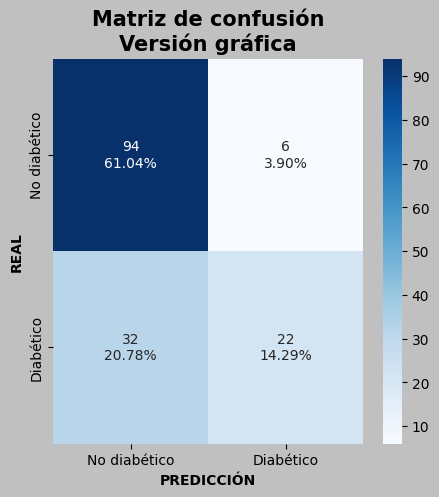

In [ ]:
# Matriz de confusión de forma gráfica
matriz = confusion_matrix(y_test, pipeline_clasificacion.predict(X_test))
plt.figure(figsize=(5,5),facecolor= 'silver')
clases = ["No diabético","Diabético"]
group_counts = ["{0:0.0f}".format(value) for value in matriz.flatten()]
# Calcula porcentajes
group_percentages = ["{0:.2%}".format(value) for value in matriz.flatten()/matriz.sum()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
# Genera la gráfica
sns.heatmap(matriz, annot=labels, fmt='', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión\nVersión gráfica", fontsize=15, fontweight="bold")
plt.xlabel("PREDICCIÓN", fontsize=10, fontweight="bold")
plt.ylabel("REAL", fontsize=10, fontweight="bold")
plt.show()

Al momento de imprimir la matriz, si se quisiera usar el objeto `modelo_arbol` se debería obtener la matriz de esta forma:

```python
X_test_transf = pipeline_clasificacion.named_steps["preprocessor"].transform(X_test)
matriz = confusion_matrix(y_test, modelo_arbol.predict(X_test_transf))
```

# Usando `hiperparámetros`

Un `hiperparámetro` que es posible ajustar en un árbol de decisión es la **profundidad máxima** (`max_depth`). Se visualiza que se tiene un mejoramiento inicial del rendimiento al aumentar la profundidad, para después descender debido al sobreajuste.

In [ ]:
depths = range(1,10)
performances = []
for depth in depths:
    current_tree = DecisionTreeClassifier( # Instancia el árbol de decisión.
        max_depth=depth,
        criterion = "entropy"
    )
    roc_auc = cross_val_score(
          current_tree,
          diabetes_features,
          diabetes_label,
          scoring="roc_auc"
      ).mean()
    performances.append(roc_auc)

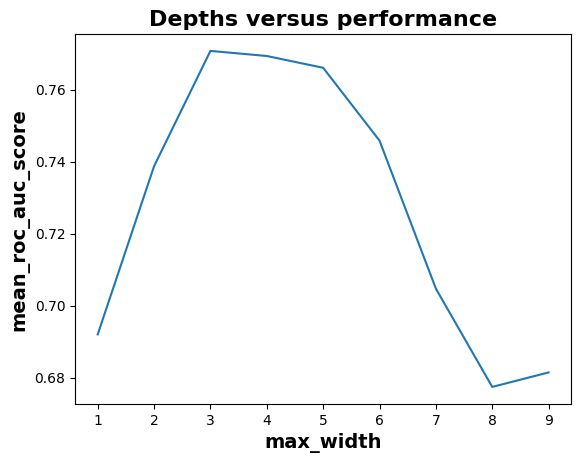

In [ ]:
plt.plot(
    depths,
    performances
)
plt.xlabel("max_width", fontsize=14, fontweight="bold")
plt.ylabel("mean_roc_auc_score", fontsize=14, fontweight="bold")
plt.title("Depths versus performance", fontsize=16, fontweight="bold")
plt.show()